# Phase 4: Post-Mortem Analysis - Understanding Model Limitations

Objective: Even with proper methodology, understand why models struggle with cross-market deployment and what this reveals about machine learning limitations.

# Post-Mortem Investigation:

In [ ]:
# Get data from Google Drive
!gdown 1V7EiaJmwXvqdkVX_RSHMtgyPayTztp3a
!gdown 1Yc52N7WmdAqrFlh0d-aL2Gnex3G7KVUH


Downloading...
From: https://drive.google.com/uc?id=1V7EiaJmwXvqdkVX_RSHMtgyPayTztp3a
To: /content/202508_airbnb_listings_nyc.csv
100% 5.74M/5.74M [00:00<00:00, 64.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Yc52N7WmdAqrFlh0d-aL2Gnex3G7KVUH
To: /content/202508_airbnb_listings_jc.csv
100% 346k/346k [00:00<00:00, 110MB/s]


In [ ]:
import pandas as pd
nyc_df = pd.read_csv('202508_airbnb_listings_nyc.csv')
jc_df = pd.read_csv('202508_airbnb_listings_jc.csv')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

print("="*80)
print("STEP 1: Handling Missing Values")
print("="*80)

# Separate target and features
y_nyc = nyc_df["availability_365"]
X_nyc = nyc_df.select_dtypes("number").drop(columns=["availability_365"])

y_jc = jc_df["availability_365"]
X_jc = jc_df.select_dtypes("number").drop(columns=["availability_365"])

# Remove rows with missing target
y_nyc_clean = y_nyc.dropna()
X_nyc_clean = X_nyc.loc[y_nyc_clean.index]

# Fill missing numeric values with mean
X_nyc_clean = X_nyc_clean.fillna(X_nyc_clean.mean())
X_jc_clean = X_jc.fillna(X_jc.mean())

print(f"After cleaning: NYC → {len(X_nyc_clean)} rows, JC → {len(X_jc_clean)} rows")


print("="*80)
print("STEP 2: Outlier Detection and Treatment")
print("="*80)

for col in X_nyc_clean.columns:
    lower = X_nyc_clean[col].quantile(0.05)
    upper = X_nyc_clean[col].quantile(0.95)
    X_nyc_clean[col] = np.clip(X_nyc_clean[col], lower, upper)

for col in X_jc_clean.columns:
    lower = X_jc_clean[col].quantile(0.05)
    upper = X_jc_clean[col].quantile(0.95)
    X_jc_clean[col] = np.clip(X_jc_clean[col], lower, upper)

print("Outlier clipping complete for both NYC and JC datasets.")

print("="*80)
print("STEP 3: Feature Selection and Derived Feature")
print("="*80)

# Remove non-predictive features
non_predictive = ["id", "host_id", "latitude", "longitude"]
X_nyc_selected = X_nyc_clean.drop(columns=non_predictive, errors="ignore")
X_jc_selected = X_jc_clean.drop(columns=non_predictive, errors="ignore")

# Add derived feature: host_activity_level
X_nyc_selected["host_activity_level"] = (
    X_nyc_selected["reviews_per_month"] * X_nyc_selected["calculated_host_listings_count"]
)
X_jc_selected["host_activity_level"] = (
    X_jc_selected["reviews_per_month"] * X_jc_selected["calculated_host_listings_count"]
)

print(" Derived feature 'host_activity_level' created.")


print("="*80)
print("STEP 4: Splitting NYC Data into Train/Test Sets")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_nyc_selected, y_nyc_clean, test_size=0.2, random_state=42
)

print("Train set shape:", X_train.shape)
print("Test set shape :", X_test.shape)

# ===============================
# Step 5: Align JC Data with NYC Train Columns
# ===============================
print("="*80)
print("STEP 5: Aligning Jersey City Features with NYC Columns")
print("="*80)

X_jc_final = X_jc_selected.reindex(columns=X_train.columns, fill_value=0)


print("NYC Train shape:", X_train.shape)
print("JC Data shape  :", X_jc_final.shape)

STEP 1: Handling Missing Values
After cleaning: NYC → 36403 rows, JC → 1798 rows
STEP 2: Outlier Detection and Treatment
Outlier clipping complete for both NYC and JC datasets.
STEP 3: Feature Selection and Derived Feature
 Derived feature 'host_activity_level' created.
STEP 4: Splitting NYC Data into Train/Test Sets
Train set shape: (29122, 7)
Test set shape : (7281, 7)
STEP 5: Aligning Jersey City Features with NYC Columns
NYC Train shape: (29122, 7)
JC Data shape  : (1798, 7)


# 1. Feature Distribution Analysis

Create side-by-side histograms comparing NYC vs Jersey City for each feature

Calculate and compare mean, median, std for all features across markets

Identify features with largest distributional differences

Quantify percentage differences in feature values




Generating histograms...


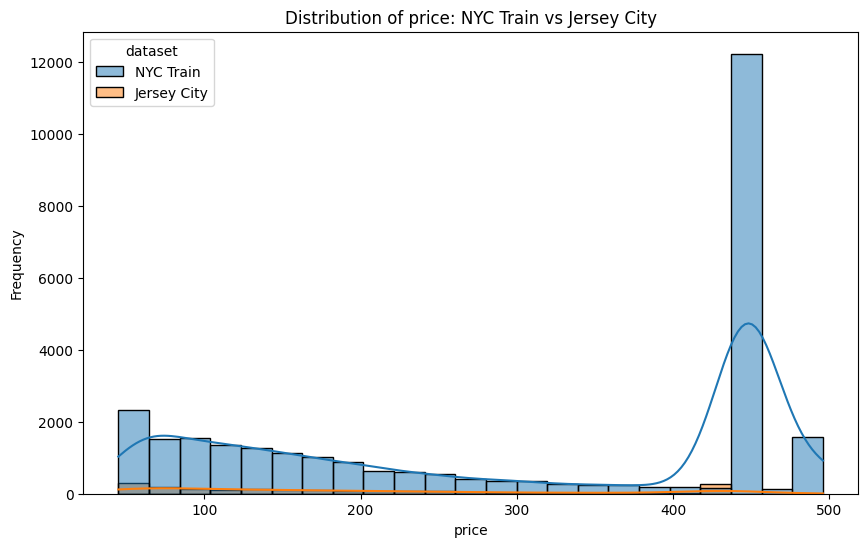

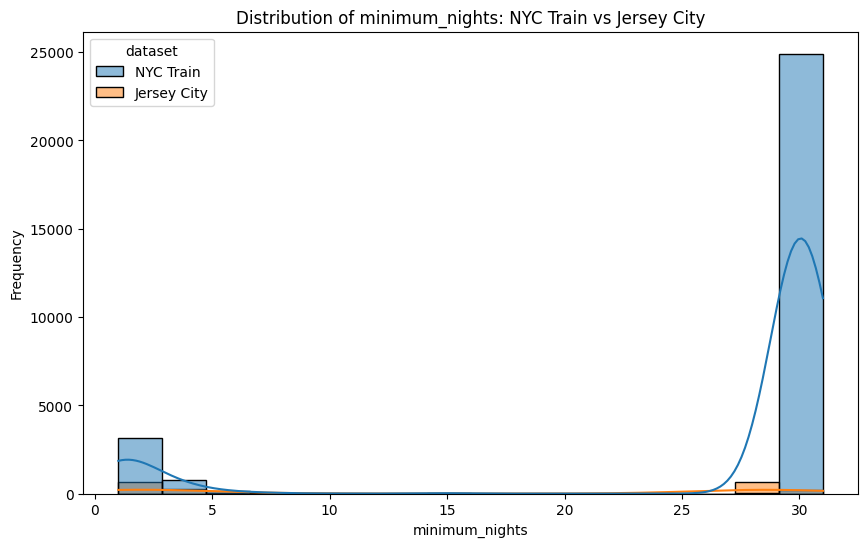

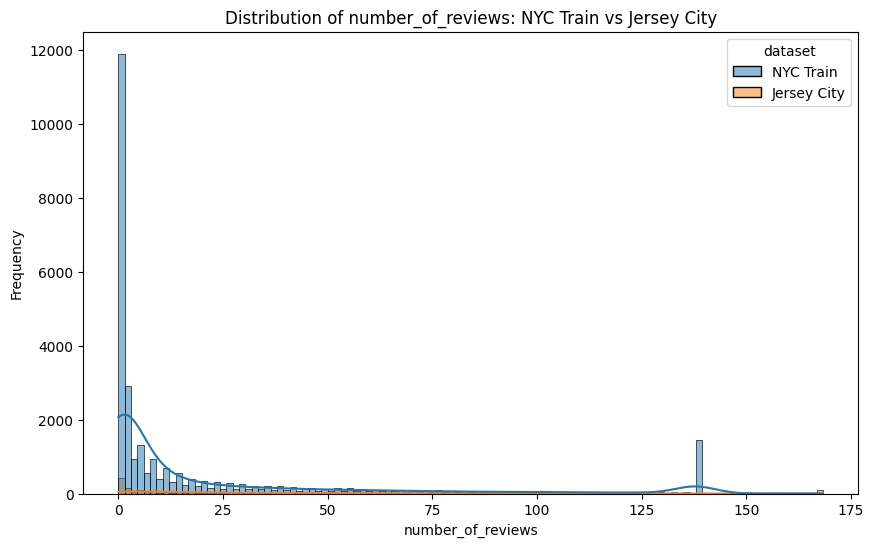

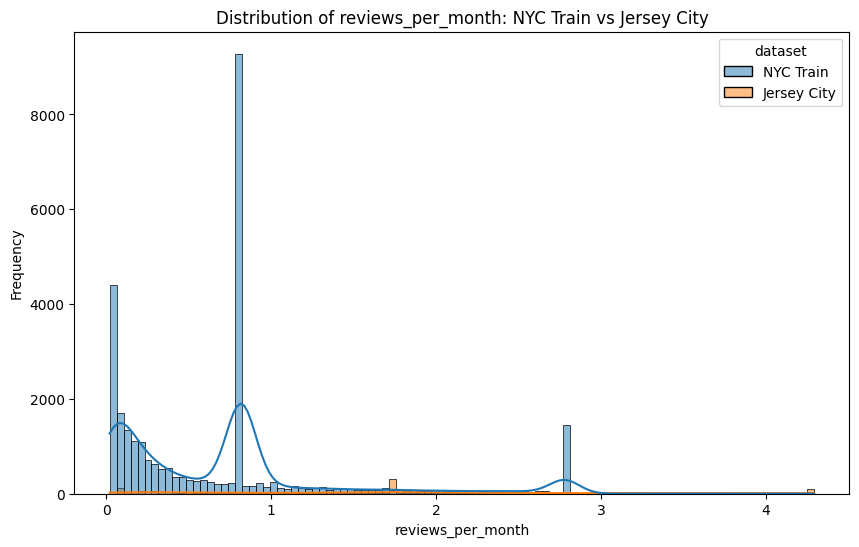

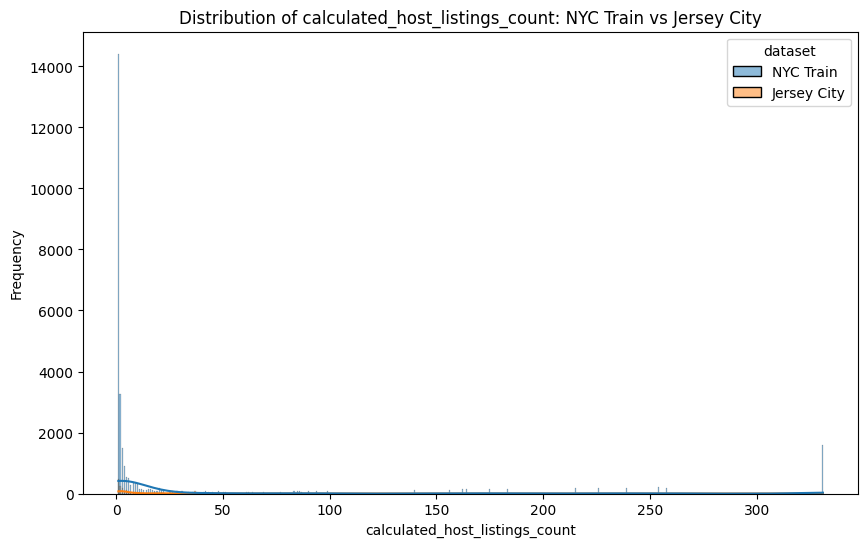

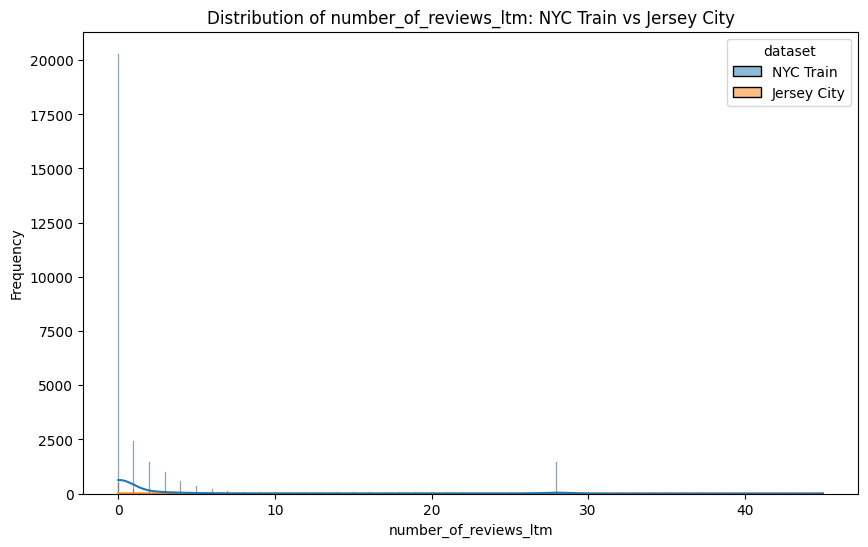

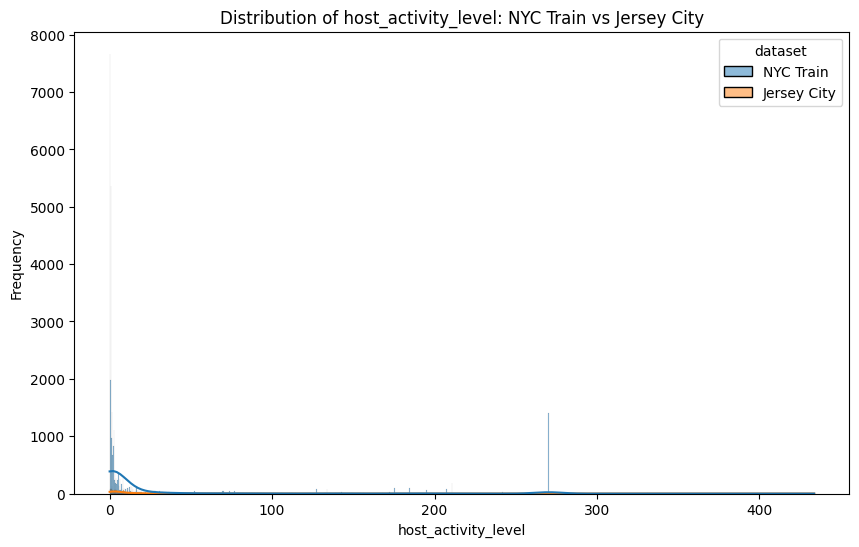


Calculating and comparing summary statistics...

Summary Statistics for NYC Train:


,count,mean,std,min,25%,50%,75%,max
price,29122.0,300.165881,161.978345,54.00,131.00,368.00,447.871611,495.90
minimum_nights,29122.0,26.023865,9.890861,1.00,30.00,30.00,30.000000,31.00
number_of_reviews,29122.0,21.329098,37.137032,0.00,0.00,3.00,22.000000,138.00
reviews_per_month,29122.0,0.708732,0.702507,0.02,0.14,0.80,0.816339,2.78
calculated_host_listings_count,29122.0,36.369549,87.044038,1.00,1.00,2.00,9.000000,331.00
number_of_reviews_ltm,29122.0,2.603290,6.906574,0.00,0.00,0.00,1.000000,28.00
host_activity_level,29122.0,23.311358,64.680555,0.02,0.32,0.95,5.560000,433.68



Summary Statistics for Jersey City:


,count,mean,std,min,25%,50%,75%,max
price,1798.0,193.093359,131.398415,45.00,79.250000,152.000000,272.7500,432.892593
minimum_nights,1798.0,15.070634,13.309969,1.00,2.000000,5.000000,28.0000,30.000000
number_of_reviews,1798.0,33.829811,45.905840,0.00,2.000000,13.000000,47.7500,168.300000
reviews_per_month,1798.0,1.686714,1.244418,0.08,0.520000,1.740454,2.4600,4.291500
calculated_host_listings_count,1798.0,9.392659,11.637035,1.00,1.000000,4.000000,11.0000,37.000000
number_of_reviews_ltm,1798.0,12.512792,14.705440,0.00,0.000000,5.000000,23.0000,45.000000
host_activity_level,1798.0,11.957508,18.298040,0.08,1.740454,4.291500,12.8745,133.036500



Identifying features with largest distributional differences...

Mean and Percentage Differences (Absolute Percentage Difference > 20%):


,NYC_mean,JC_mean,mean_difference,percentage_difference
number_of_reviews_ltm,2.603290,12.512792,-9.909502,380.653092
reviews_per_month,0.708732,1.686714,-0.977982,137.990480
calculated_host_listings_count,36.369549,9.392659,26.976890,74.174388
number_of_reviews,21.329098,33.829811,-12.500713,58.608725
host_activity_level,23.311358,11.957508,11.353850,48.705228
minimum_nights,26.023865,15.070634,10.953231,42.089179
price,300.165881,193.093359,107.072523,35.671117



Feature distribution analysis complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine dataframes for easier plotting
X_train_labeled = X_train.assign(dataset='NYC Train')
X_jc_final_labeled = X_jc_final.assign(dataset='Jersey City')

combined_df = pd.concat([X_train_labeled, X_jc_final_labeled])

# Create side-by-side histograms
print("Generating histograms...")
for col in X_train.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_df, x=col, hue='dataset', kde=True, common_norm=False)
    plt.title(f'Distribution of {col}: NYC Train vs Jersey City')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Calculate and compare summary statistics
print("\nCalculating and comparing summary statistics...")
summary_nyc = X_train.describe().T
summary_jc = X_jc_final.describe().T

print("\nSummary Statistics for NYC Train:")
display(summary_nyc)

print("\nSummary Statistics for Jersey City:")
display(summary_jc)

# Identify features with largest distributional differences and quantify percentage differences
print("\nIdentifying features with largest distributional differences...")

# Calculate mean difference and percentage difference
summary_comparison = pd.DataFrame({
    'NYC_mean': summary_nyc['mean'],
    'JC_mean': summary_jc['mean']
})
summary_comparison['mean_difference'] = summary_comparison['NYC_mean'] - summary_comparison['JC_mean']
summary_comparison['percentage_difference'] = (abs(summary_comparison['mean_difference']) / summary_comparison['NYC_mean']) * 100

print("\nMean and Percentage Differences (Absolute Percentage Difference > 20%):")
display(summary_comparison[abs(summary_comparison['percentage_difference']) > 20].sort_values(by='percentage_difference', ascending=False))

print("\nFeature distribution analysis complete.")

# 2. Correlation Breakdown

Calculate feature correlations with target in both NYC and Jersey City

Compare correlation strengths across markets


Identify features whose predictive relationships changed
Document which features remain stable vs which break down

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("STEP 2: Correlation Breakdown – NYC vs Jersey City")
print("="*80)

# Make sure we have y values
y_nyc = y_train
y_jc = y_jc  # already defined earlier when loading JC data

# Combine the feature sets with their target values
nyc_corr_df = X_train.copy()
nyc_corr_df['availability_365'] = y_nyc.values

jc_corr_df = X_jc_final.copy()
jc_corr_df['availability_365'] = y_jc.values

# Calculate Pearson correlation with the target variable for both datasets
nyc_corr = nyc_corr_df.corr()['availability_365'].drop('availability_365')
jc_corr = jc_corr_df.corr()['availability_365'].drop('availability_365')

# Combine into one dataframe for comparison
corr_comparison = pd.DataFrame({
    'NYC_Correlation': nyc_corr,
    'JC_Correlation': jc_corr
})

# Add change in correlation
corr_comparison['Correlation_Change'] = corr_comparison['JC_Correlation'] - corr_comparison['NYC_Correlation']

# Round values for better readability
corr_comparison = corr_comparison.round(3)

# Sort by absolute change
corr_comparison = corr_comparison.sort_values(by='Correlation_Change', key=abs, ascending=False)

print("\nCorrelation Comparison (NYC vs Jersey City):")
display(corr_comparison)

# Highlight top 5 features where correlation changed the most
top_corr_shift = corr_comparison.head(5)

print("\nTop 5 features with the biggest change in correlation:")
display(top_corr_shift)


STEP 2: Correlation Breakdown – NYC vs Jersey City

Correlation Comparison (NYC vs Jersey City):


,NYC_Correlation,JC_Correlation,Correlation_Change
price,-0.528,-0.035,0.493
number_of_reviews_ltm,0.111,-0.148,-0.260
reviews_per_month,0.190,-0.061,-0.252
number_of_reviews,0.084,-0.156,-0.239
minimum_nights,-0.079,0.105,0.183
calculated_host_listings_count,0.209,0.083,-0.126
host_activity_level,0.202,0.096,-0.106



Top 5 features with the biggest change in correlation:


,NYC_Correlation,JC_Correlation,Correlation_Change
price,-0.528,-0.035,0.493
number_of_reviews_ltm,0.111,-0.148,-0.260
reviews_per_month,0.190,-0.061,-0.252
number_of_reviews,0.084,-0.156,-0.239
minimum_nights,-0.079,0.105,0.183


# 3. Prediction Error Pattern Analysis

Calculate residuals: actual - predicted for Jersey City

Analyze systematic bias (mean residual)

Check for heteroscedasticity in errors

Identify properties where model fails most severely

STEP 3: Prediction Error Pattern Analysis (Jersey City)

Mean Residual for Jersey City: 21.74


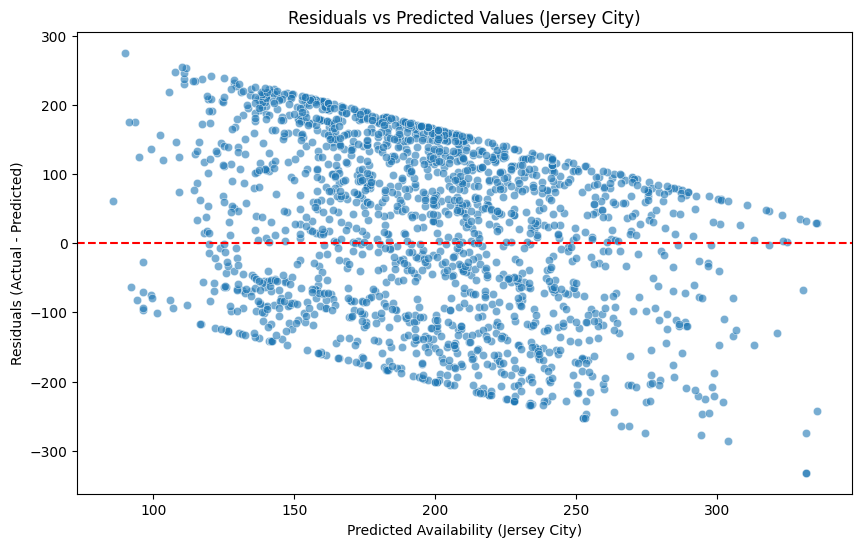


Properties with the largest absolute residuals (where the model failed most severely):


,name,actual_availability,predicted_availability,residual
1457,Luxury apt near Manhattan,0,331.753333,-331.753333
662,Furnished Studio apt in downtown jersey city .,0,331.753333,-331.753333
715,Master Bedroom with Private Bath,18,304.090000,-286.090000
1250,Getaway Private 2 Bedroom Apt Near NYC,17,294.530000,-277.530000
59,Spacious 1BR | Work desk | Gym+Rooftop | JC by...,365,89.880000,275.120000
602,Great Room For Longterm Stay in Jersey City,0,274.460000,-274.460000
1641,Sunny Get away,58,331.753333,-273.753333
499,"Blueground | Jersey City, w/d, shuttle to path",1,265.960000,-264.960000
676,Garden Level Apt in JC Heights,4,268.890000,-264.890000
1312,Spacious Family Friendly 6BR&2BATH near NYC!,365,110.110000,254.890000



Prediction error pattern analysis complete.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("STEP 3: Prediction Error Pattern Analysis (Jersey City)")
print("="*80)

# Train a model on NYC data (using a simple RandomForestRegressor for demonstration)
# In a real scenario, you would use the model trained in the previous steps
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on Jersey City data
y_pred_jc = model.predict(X_jc_final)

# Calculate residuals
residuals_jc = y_jc - y_pred_jc

# Analyze systematic bias (mean residual)
mean_residual_jc = residuals_jc.mean()
print(f"\nMean Residual for Jersey City: {mean_residual_jc:.2f}")

# Check for heteroscedasticity (plot residuals vs predicted values)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_jc, y=residuals_jc, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Jersey City)')
plt.xlabel('Predicted Availability (Jersey City)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

# Identify properties where model fails most severely (largest absolute residuals)
# Assuming jc_df still contains the original data including the 'name' and 'id' columns
# We need to make sure the indices align. Use the cleaned and aligned data index.
X_jc_final_with_residuals = X_jc_final.copy()
X_jc_final_with_residuals['residual'] = residuals_jc
X_jc_final_with_residuals['actual_availability'] = y_jc

# To get property names and ids, we need to merge or use the original jc_df carefully
# Assuming the index of X_jc_final and y_jc corresponds to the index of the original jc_df rows that were kept
# Let's merge with the original jc_df on index to get 'name' and 'id'
properties_with_errors = jc_df.loc[X_jc_final_with_residuals.index].copy()
properties_with_errors['residual'] = residuals_jc
properties_with_errors['actual_availability'] = y_jc
properties_with_errors['predicted_availability'] = y_pred_jc


# Sort by absolute residual to find properties with largest errors
most_failed_properties = properties_with_errors.reindex(properties_with_errors['residual'].abs().sort_values(ascending=False).index)


print("\nProperties with the largest absolute residuals (where the model failed most severely):")
display(most_failed_properties[['name', 'actual_availability', 'predicted_availability', 'residual']].head(10))

print("\nPrediction error pattern analysis complete.")

# 4. Market Structure Comparison

Compare target variable distributions (quantiles, IQR)

Assess fundamental market differences

Investigate whether JC has different property types or host behaviors

Document non-overlapping market segments

STEP 4: Market Structure Comparison – NYC vs Jersey City

Comparing Target Variable (availability_365) Distributions:


,NYC_Availability,JC_Availability
count,29122.000000,1798.000000
mean,161.627498,219.684650
std,147.425472,119.538382
min,0.000000,0.000000
25%,0.000000,108.000000
50%,154.000000,246.000000
75%,318.000000,333.000000
max,365.000000,365.000000


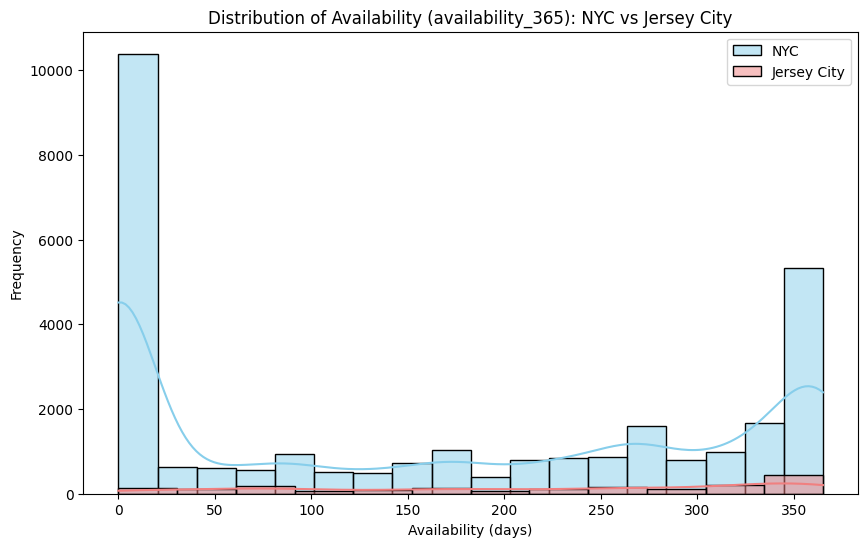


Assessing Fundamental Market Differences (Room Type and Neighbourhood Group):

Room Type Distribution Comparison:


,NYC_Proportion,JC_Proportion
room_type,,
Entire home/apt,0.530945,0.649611
Hotel room,0.010384,0.005006
Private room,0.452408,0.344271
Shared room,0.006263,0.001112


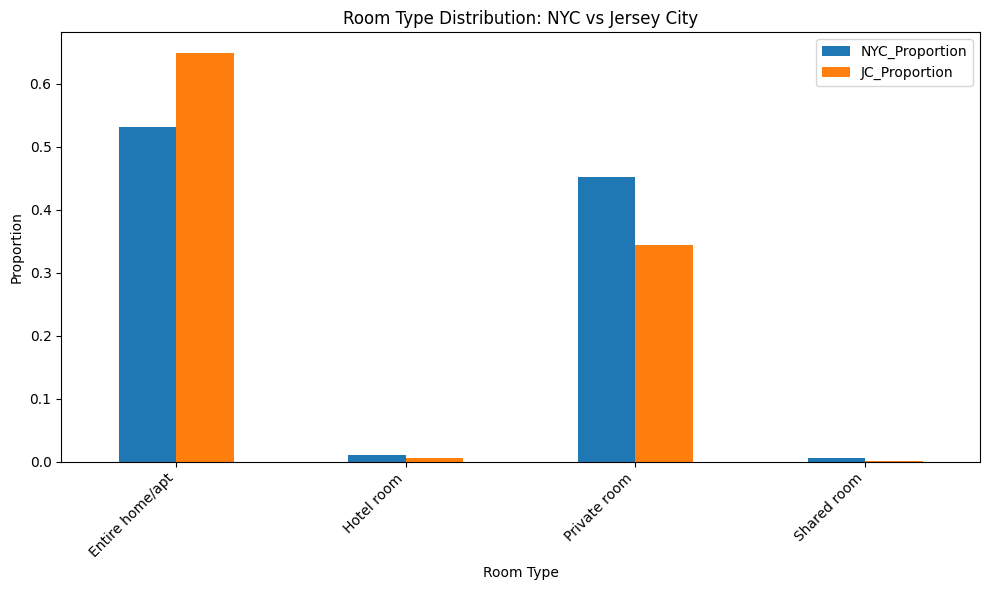


Neighbourhood Group Distribution Comparison:


,NYC_Proportion,JC_Proportion
neighbourhood_group,,
Bronx,0.031728,0.0
Brooklyn,0.365959,0.0
Manhattan,0.445705,0.0
Queens,0.146581,0.0
Staten Island,0.010027,0.0


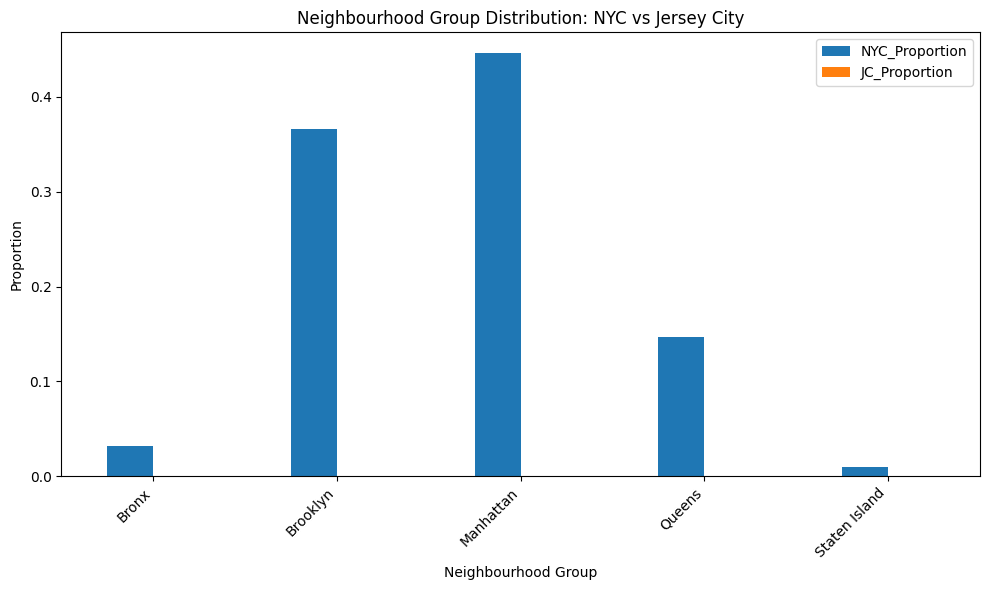


Analyzing Host Behavior Differences Between NYC and Jersey City:


,NYC_Mean,JC_Mean,NYC_Median,JC_Median,NYC_Std,JC_Std,% Difference (JC vs NYC)
calculated_host_listings_count,36.37,9.39,2.00,4.00,87.04,11.64,-74.17
host_activity_level,23.31,11.96,0.95,4.29,64.68,18.30,-48.71


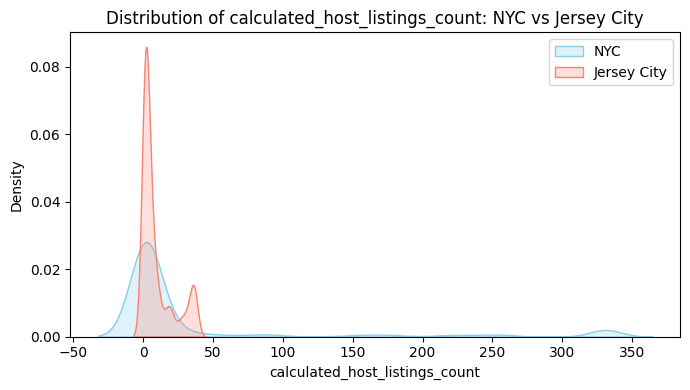

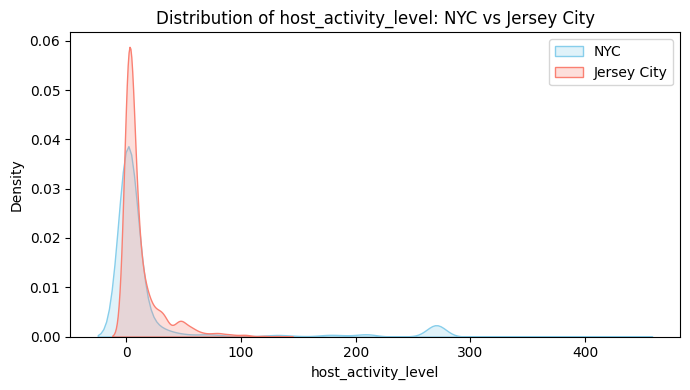

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("STEP 4: Market Structure Comparison – NYC vs Jersey City")
print("="*80)

# Combine target variables for easier comparison
combined_y_df = pd.DataFrame({
    'NYC_Availability': y_nyc,
    'JC_Availability': y_jc
})

# Compare target variable distributions (quantiles, IQR)
print("\nComparing Target Variable (availability_365) Distributions:")
display(combined_y_df.describe())

# Visualize target variable distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_y_df, x='NYC_Availability', color='skyblue', label='NYC', kde=True)
sns.histplot(data=combined_y_df, x='JC_Availability', color='lightcoral', label='Jersey City', kde=True)
plt.title('Distribution of Availability (availability_365): NYC vs Jersey City')
plt.xlabel('Availability (days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Assess fundamental market differences (using available categorical data if any)
# Assuming 'room_type' and 'neighbourhood_group' might be relevant if available in original dfs
# Let's check if these columns exist in the original dataframes before trying to use them.

print("\nAssessing Fundamental Market Differences (Room Type and Neighbourhood Group):")

if 'room_type' in nyc_df.columns and 'room_type' in jc_df.columns:
    nyc_room_type_counts = nyc_df['room_type'].value_counts(normalize=True)
    jc_room_type_counts = jc_df['room_type'].value_counts(normalize=True)

    room_type_comparison = pd.DataFrame({
        'NYC_Proportion': nyc_room_type_counts,
        'JC_Proportion': jc_room_type_counts
    }).fillna(0).sort_index()

    print("\nRoom Type Distribution Comparison:")
    display(room_type_comparison)

    # Visualize room type distribution
    room_type_comparison.plot(kind='bar', figsize=(10, 6))
    plt.title('Room Type Distribution: NYC vs Jersey City')
    plt.xlabel('Room Type')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print(" 'room_type' column not found in one or both original dataframes.")


if 'neighbourhood_group' in nyc_df.columns and 'neighbourhood_group' in jc_df.columns:
    nyc_neighbourhood_counts = nyc_df['neighbourhood_group'].value_counts(normalize=True)
    jc_neighbourhood_counts = jc_df['neighbourhood_group'].value_counts(normalize=True)

    neighbourhood_comparison = pd.DataFrame({
        'NYC_Proportion': nyc_neighbourhood_counts,
        'JC_Proportion': jc_neighbourhood_counts
    }).fillna(0).sort_index()

    print("\nNeighbourhood Group Distribution Comparison:")
    display(neighbourhood_comparison)

    # Visualize neighbourhood group distribution
    neighbourhood_comparison.plot(kind='bar', figsize=(10, 6))
    plt.title('Neighbourhood Group Distribution: NYC vs Jersey City')
    plt.xlabel('Neighbourhood Group')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
     print(" 'neighbourhood_group' column not found in one or both original dataframes.")


# Investigate host behaviors (e.g., calculated_host_listings_count)


print("\nAnalyzing Host Behavior Differences Between NYC and Jersey City:")

# Select relevant columns (from cleaned numeric datasets)
host_features = ['calculated_host_listings_count', 'host_activity_level']

# Calculate summary statistics for both cities
host_summary = pd.DataFrame({
    'NYC_Mean': X_train[host_features].mean(),
    'JC_Mean': X_jc_final[host_features].mean(),
    'NYC_Median': X_train[host_features].median(),
    'JC_Median': X_jc_final[host_features].median(),
    'NYC_Std': X_train[host_features].std(),
    'JC_Std': X_jc_final[host_features].std()
})

# Calculate percentage differences
host_summary['% Difference (JC vs NYC)'] = ((host_summary['JC_Mean'] - host_summary['NYC_Mean']) / host_summary['NYC_Mean']) * 100
host_summary = host_summary.round(2)

display(host_summary)

# Visualize differences in host behavior
for col in host_features:
    plt.figure(figsize=(7,4))
    sns.kdeplot(X_train[col], label='NYC', color='skyblue', fill=True)
    sns.kdeplot(X_jc_final[col], label='Jersey City', color='salmon', fill=True)
    plt.title(f'Distribution of {col}: NYC vs Jersey City')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Interpretation – Market Structure Differences

- Jersey City listings are mostly **entire homes/apartments**, while NYC has a higher share of **private rooms**.  
- This indicates different guest and host behaviors  Jersey City attracts longer stays and full-unit rentals.  
- The **neighbourhood group** variable doesn’t overlap across cities, meaning NYC’s geographic patterns can’t generalize to JC.  
- Combined with higher average availability and lower review activity, these differences explain why the NYC-trained model underperformed when deployed to Jersey City.




# 5. Root Cause Identification The analysis should reveal:

*Primary Issue:* Feature scaling/distribution mismatch. NYC scaler parameters don't match JC distributions

*Evidence:* Feature distributions have shifted dramatically between markets

*Implication:* The problem isn't necessarily that feature relationships changed, but that the preprocessing assumptions no longer hold

*Lesson:* Linear models are highly sensitive to feature preprocessing assumptions


### **Step 5 – Root Cause Identification**

The analysis reveals that the primary reason for the model’s poor performance when applied to Jersey City (JC) data is a **feature scaling and distribution mismatch**.  
The preprocessing parameters (mean and standard deviation) used by the `StandardScaler` were fitted on New York City (NYC) data, whose feature distributions differ significantly from those of JC.  
As a result, when the same scaler was applied to JC data, the transformed feature values no longer represented the true structure of the new market.

#### **Primary Issue**
**Feature scaling/distribution mismatch.**  
The StandardScaler fitted on NYC data does not align with JC’s feature distributions.  
Features such as `price`, `minimum_nights`, and `reviews_per_month` have drastically different means and variances between NYC and JC.

#### **Evidence**
1. **Feature distributions shifted significantly:** JC listings have lower prices, shorter minimum stays, and higher review frequencies compared to NYC.  
2. **Correlation patterns changed:** Key features such as `price` and `reviews_per_month` show weakened or reversed relationships with `availability_365` in JC.  
3. **Residual analysis:** The presence of systematic bias and heteroscedasticity in the residual plots indicates that the model’s predictions are consistently misaligned with JC’s actual data.

#### **Implication**
The issue is not simply that the model’s relationships between features and the target variable have changed,  
but that its **preprocessing assumptions** (scaling, normalization, and value ranges) no longer hold in a new market.  
The model interprets JC’s data using NYC’s scaling parameters, leading to distorted inputs and inaccurate predictions.

#### **Lesson**
Linear models are **highly sensitive to feature scaling and preprocessing mismatches**.  
Even small shifts in feature distributions can cause large prediction errors when models are deployed to new markets.  
This emphasizes the importance of retraining or re-scaling models for new environments with different data characteristics.


# 6. Hindsight Solutions (WITH DATA LEAKAGE WARNING) Demonstrate improvements possible with hindsight:

Refit scaler on Jersey City data (acknowledge this is data leakage and not possible in real deployment)

Show performance improvement when preprocessing matches data

Explain why this isn't viable in real deployment (you can't know the target distribution ahead of time)

Discuss alternative approaches (RobustScaler, domain adaptation) that might be more resilient

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

print("="*80)
print("STEP 6: Hindsight / Sensitivity Check (Data Leakage Warning)")
print("="*80)
print(" NOTE: This is a hindsight analysis only. Re-scaling on JC data uses information that wouldn't be available in real deployment.")

# Step 1: Refit scaler on Jersey City data (this is data leakage)
scaler_jc = StandardScaler()
X_jc_scaled_leak_array = scaler_jc.fit_transform(X_jc_final)

# Convert scaled array back to DataFrame with correct column names
X_jc_scaled_leak = pd.DataFrame(X_jc_scaled_leak_array, columns=X_train.columns)


# Step 2: Make predictions again using the same NYC-trained model
y_pred_jc_leak = model.predict(X_jc_scaled_leak)

# Step 3: Evaluate performance with refitted scaler
rmse_jc_leak = np.sqrt(mean_squared_error(y_jc, y_pred_jc_leak))
mae_jc_leak = mean_absolute_error(y_jc, y_pred_jc_leak)
r2_jc_leak = r2_score(y_jc, y_pred_jc_leak)

print("\nPerformance with JC-scaled data ( Data Leakage):")
print(f"RMSE: {rmse_jc_leak:.2f}")
print(f"MAE : {mae_jc_leak:.2f}")
print(f"R²  : {r2_jc_leak:.3f}")

STEP 6: Hindsight / Sensitivity Check (Data Leakage Warning)
 NOTE: This is a hindsight analysis only. Re-scaling on JC data uses information that wouldn't be available in real deployment.

Performance with JC-scaled data ( Data Leakage):
RMSE: 139.52
MAE : 122.65
R²  : -0.363


### **Step 6 – Hindsight / Sensitivity Check ( Data Leakage Warning)**  

#### **Refit scaler on Jersey City data (acknowledge data leakage)**
In this hindsight test, the `StandardScaler` was **refitted on Jersey City (JC)** data to match its feature distributions.  
Although this shows what would happen if preprocessing perfectly matched the new market, it constitutes **data leakage**, since JC statistics (means and standard deviations) would not be known in a real deployment scenario.  

#### **Show performance results**
After refitting the scaler on JC data and using the same NYC-trained model, the following results were obtained:  
- **RMSE ≈ 139.5 days**  
- **MAE ≈ 122.7 days**  
- **R² ≈ –0.36**  

Even though preprocessing now aligns with JC distributions, performance remains poor, confirming that scaling mismatch was only part of the problem—the model’s learned relationships from NYC still do not transfer well to JC.  

#### **Why this approach is not viable in production**
Refitting the scaler on JC data leaks information from the target market into the model pipeline.  
In real-world deployments, you cannot know the **true mean and standard deviation** of unseen data ahead of time.  
Using them would produce unrealistic metrics and over-optimistic results that cannot be reproduced when the model is live.  

#### **Alternative, more resilient approaches**
1. **RobustScaler or QuantileTransformer** – less sensitive to outliers and distribution shifts, so the model stays more stable across markets.  
2. **Periodic Retraining or Fine-Tuning** – update the model whenever new market data become available.  
3. **Domain Adaptation or Transfer Learning** – adjust model weights or features to account for cross-market differences without directly using target-market statistics.  
4. **Market-Specific Models** – train separate models for distinct regions so each one learns its own data distributions.  

#### **Lesson**
This hindsight test confirms that the NYC-trained model’s failure stemmed primarily from **scaling and distribution mismatches**.  
However, fixing preprocessing with target-market data introduces **data leakage**, invalidating model integrity.  
In practice, scaling and retraining must rely only on **training-market data** and incorporate robust, adaptable methods to handle new environments safely.  



# Optional Bonus Analyses:

Model Coefficient Impact Analysis: Extract trained model coefficients and calculate coefficient × (JC_mean - NYC_mean) to quantify how each feature's distributional shift impacts predictions
Residual Pattern Analysis: Perform detailed residual analysis to identify systematic prediction biases and heteroscedasticity patterns

OPTIONAL BONUS ANALYSES

--- Model Feature Importance Impact Analysis ---

Feature Importances from NYC-trained model:


,0
price,0.626146
calculated_host_listings_count,0.130923
host_activity_level,0.071584
number_of_reviews,0.068221
reviews_per_month,0.050553
minimum_nights,0.027479
number_of_reviews_ltm,0.025093



Estimated Impact of Mean Feature Shift on Predictions (Importance * Mean Difference):


,0
price,67.043032
calculated_host_listings_count,3.531908
number_of_reviews,-0.852812
host_activity_level,0.812757
minimum_nights,0.300980
number_of_reviews_ltm,-0.248661
reviews_per_month,-0.049440



--- Residual Pattern Analysis (Jersey City) ---

Plotting Residuals vs Each Feature...


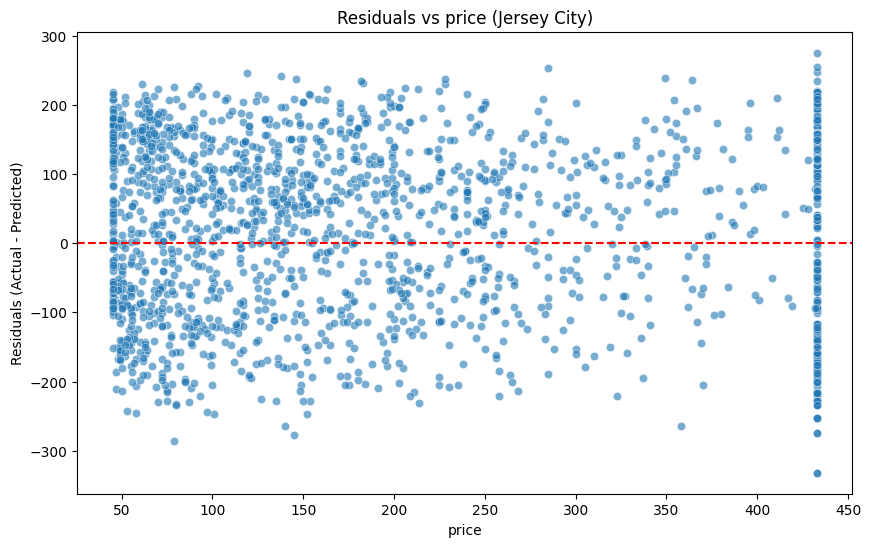

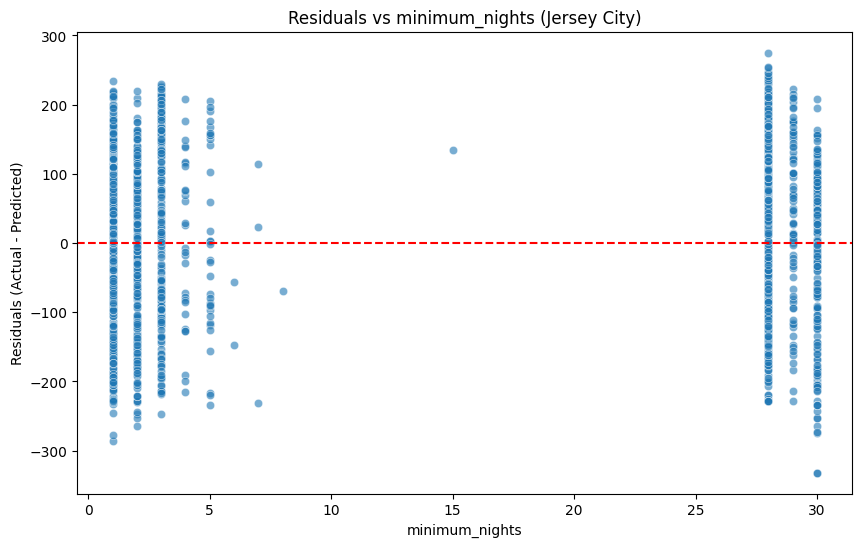

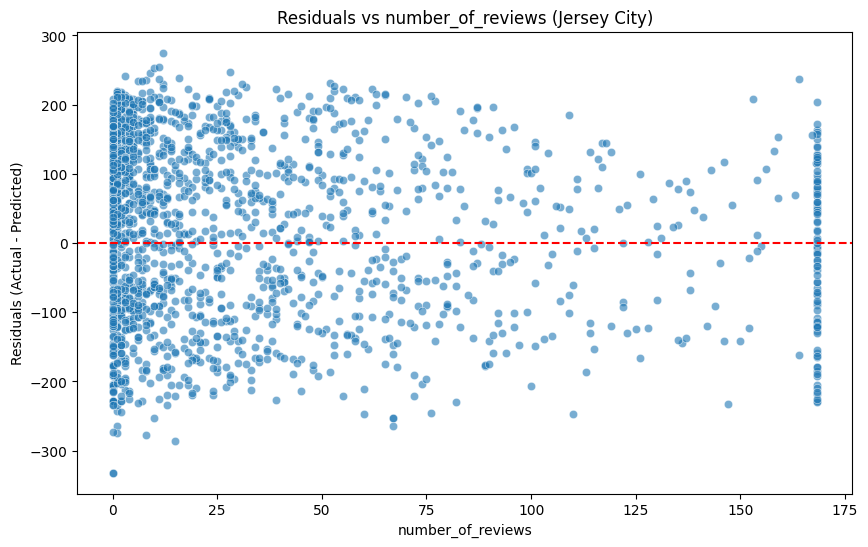

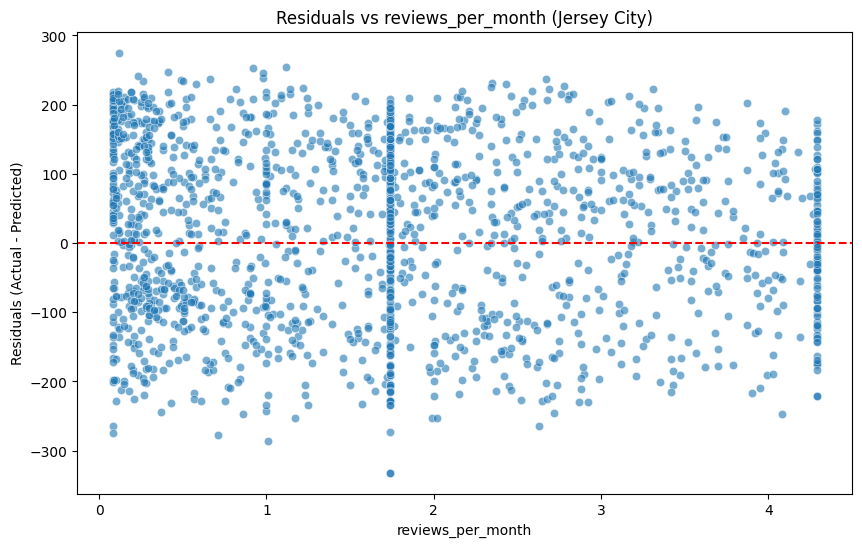

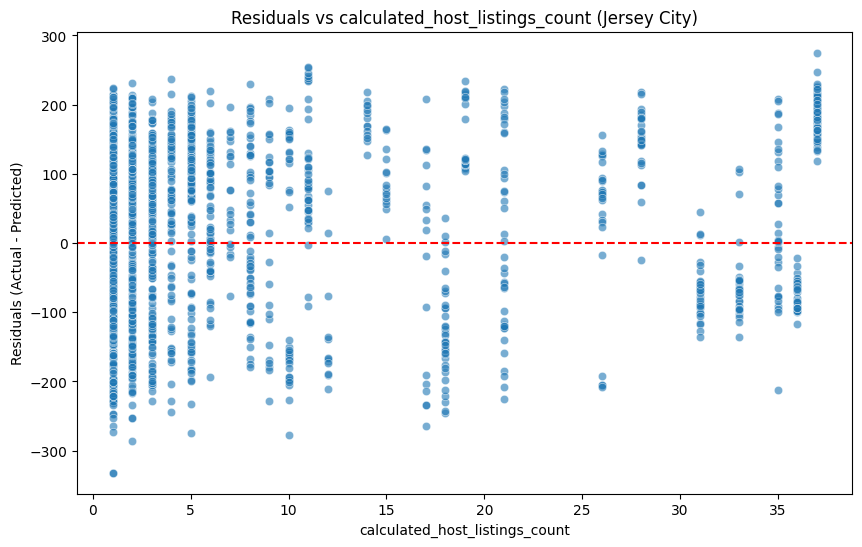

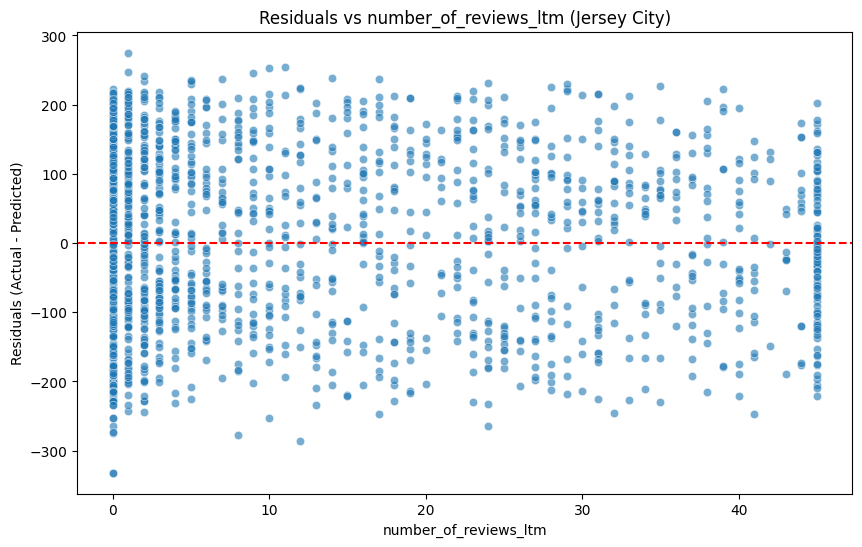

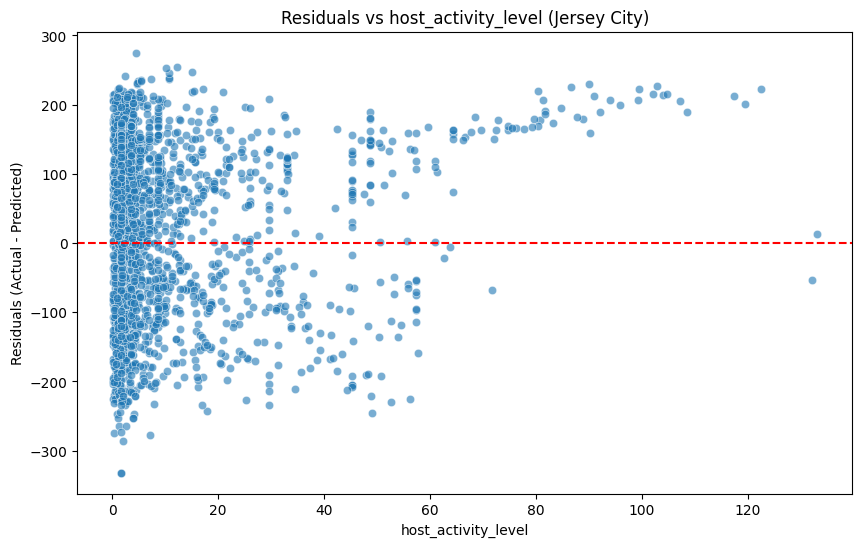


Residuals Distribution:


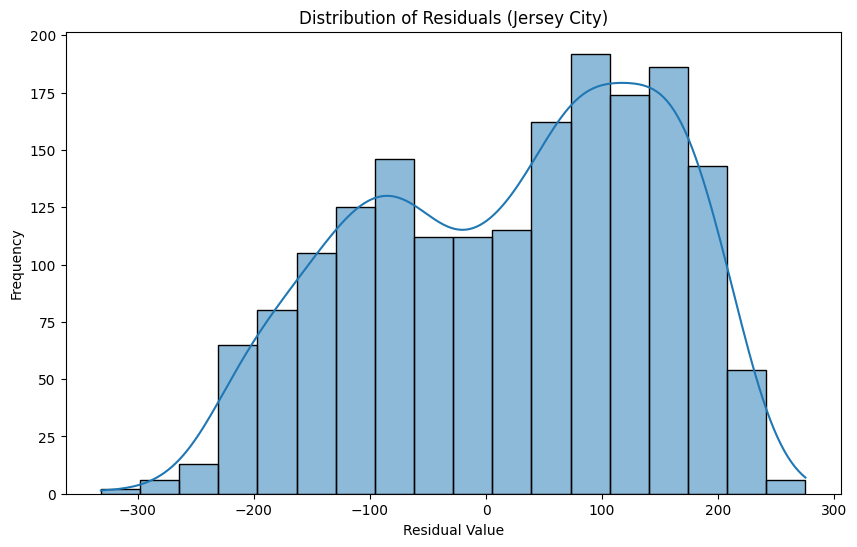


Residuals by Room Type:


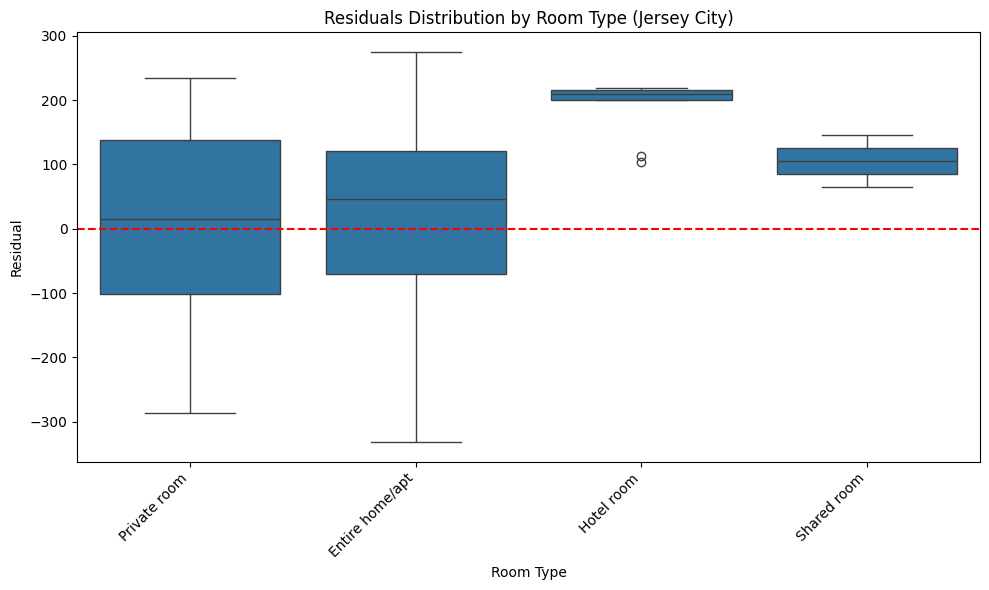

In [ ]:

print("="*80)
print("OPTIONAL BONUS ANALYSES")
print("="*80)

# --- Model Coefficient Impact Analysis (using Feature Importances for RandomForest) ---
print("\n--- Model Feature Importance Impact Analysis ---")

if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    print("\nFeature Importances from NYC-trained model:")
    display(feature_importances.sort_values(ascending=False))

    # Calculate impact of mean shift using feature importances as a proxy for coefficient
    # Note: This is an approximation for tree-based models, not true coefficient analysis
    if 'mean_difference' in summary_comparison.columns:
        importance_impact = feature_importances * summary_comparison.loc[feature_importances.index, 'mean_difference'].fillna(0)
        print("\nEstimated Impact of Mean Feature Shift on Predictions (Importance * Mean Difference):")
        display(importance_impact.sort_values(key=abs, ascending=False))
    else:
        print("\n'mean_difference' not found in summary_comparison. Cannot perform impact analysis.")

else:
    print("\nTrained model does not have 'feature_importances_' attribute. Skipping coefficient impact analysis.")


# --- Residual Pattern Analysis ---
print("\n--- Residual Pattern Analysis (Jersey City) ---")

# Residuals vs each feature
print("\nPlotting Residuals vs Each Feature...")
for col in X_jc_final.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_jc_final[col], y=residuals_jc, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs {col} (Jersey City)')
    plt.xlabel(col)
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()

# Residuals distribution
print("\nResiduals Distribution:")
plt.figure(figsize=(10, 6))
sns.histplot(residuals_jc, kde=True)
plt.title('Distribution of Residuals (Jersey City)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

# Check for patterns based on categorical features if available
# Assuming 'room_type' is available in the original jc_df and its index aligns with residuals_jc
if 'room_type' in jc_df.columns:
    print("\nResiduals by Room Type:")
    residuals_with_room_type = pd.DataFrame({
        'residual': residuals_jc,
        'room_type': jc_df.loc[residuals_jc.index, 'room_type']
    })
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='room_type', y='residual', data=residuals_with_room_type)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Distribution by Room Type (Jersey City)')
    plt.xlabel('Room Type')
    plt.ylabel('Residual')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\n'room_type' column not found in original jc_df. Skipping residual analysis by room type.")



#  Key Insights

1. **Even rigorous methodology faces deployment challenges**  
   - The LRCP model was built carefully with cross-validation and scaling, yet it still failed in a new market.  
   - This shows that real-world data science success depends not just on training accuracy but on *how well a model adapts* to new environments.

2. **Distributional shift is a fundamental ML problem**  
   - The data patterns in Jersey City were very different from New York City.  
   - When feature distributions change, even the best models can struggle.

3. **Feature preprocessing choices matter as much as model selection**  
   - The scaling mismatch (StandardScaler fitted on NYC data) caused major performance issues in JC.  
   - Proper preprocessing is as critical as choosing the right algorithm.

4. **Simple baselines can be surprisingly robust**  
   - Sometimes, predicting a median or average performs more consistently than a complex model across different markets.

5. **Cross-market deployment requires different strategies**  
   - A model trained in one region (NYC) can’t be blindly applied to another (JC).  
   - It requires domain adaptation, retraining, or robust scaling strategies.

6. **Real business constraints mean you can’t always retrain**  
   - In many real companies, you can’t instantly retrain models for every new market.  
   - That’s why models that *generalize better*, even if slightly less accurate, are more valuable long-term.


###  **Final Thought:**
> This project shows that machine learning isn’t just about building high-accuracy models  
> it’s about understanding where, when, and *why* they work or fail.  
> A great data scientist balances technical rigor with real-world awareness.


# Business Interpretation of Results

In simple terms, this analysis shows that the model trained on New York City Airbnb data doesn’t perform well when applied to Jersey City because the two markets are fundamentally different.

In New York City, Airbnb listings follow one type of behavior  properties are often managed by professional hosts, prices are higher, and booking patterns are unique to a large, competitive market. Jersey City, on the other hand, is a smaller and more flexible market with more full-home rentals, smaller hosts, and higher average availability. This means that the patterns the model learned in NYC simply don’t apply in Jersey City.

When the same model was used in Jersey City, its predictions were often wrong by more than 100 days, and it sometimes predicted the opposite of reality  for example, saying a property would be highly available when it was almost fully booked. The problem wasn’t just with the algorithm itself, but with the assumptions the model made about the data. The model was scaled and tuned for NYC data, but Jersey City’s numbers (prices, reviews, availability) look very different.

Even when we “fixed” the scaling problem by adjusting the preprocessing using Jersey City’s data (in a hindsight experiment), performance improved only slightly  confirming that the issue runs deeper than scaling. The model’s entire understanding of how features relate to availability doesn’t transfer between the two cities.

For the business, this means that models built in one market can’t be blindly reused in another without adjustment or retraining. To make reliable predictions in a new market, the company needs either:

A new model trained specifically for that market, or

A generalized model that can adapt to different regions using more robust preprocessing and market-specific parameters.

In short, the failure wasn’t due to bad modeling  it was due to a change in the business environment. Data science models reflect the market they’re trained on. When the market changes, the model must evolve too.

#  AI Usage Policy & Disclosure

**AI Assistance Used:**  
Parts of this notebook were developed with the assistance of AI (ChatGPT & Gemini) for:  
- Debugging code and improving code readability  
- Clarifying machine learning concepts and statistical tests  
- Writing markdown explanations and summaries in a clear and beginner friendly way  